 Présenté par :

 1- LOUNGOUBIYENDOLO Quentin Evrard

 2- Ndiaya GUEYE
 
 Master 1 Virtualisation Computing et Cloud

####  Partie 1– Préparation des données

##### Importation de la bibliothèque pandas

In [24]:
import pandas as pd


##### Lire seulement les 2 000 000 premières lignes (ou un autre nombre raisonnable)

In [25]:
df = pd.read_csv("data.csv", nrows=2_000_000)

##### Affichage des premières lignes

In [4]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Traffic Type,Traffic Subtype
0,192.168.1.90-192.168.1.3-53930-64738-6,192.168.1.90,53930.0,192.168.1.3,64738,6.0,01/01/1970 07:41:46 AM,52601173.0,1701.0,1793.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,Audio,Audio
1,192.168.1.3-192.168.1.90-64738-37700-6,192.168.1.3,64738.0,192.168.1.90,37700,6.0,01/01/1970 07:41:46 AM,119106942.0,36.0,57.0,...,3.416174e+06,19996926.0,14078617.0,5001511.0,1737.400069,5003516.0,5000449.0,Benign,Audio,Audio
2,192.168.1.3-192.168.1.90-22-40854-6,192.168.1.3,22.0,192.168.1.90,40854,6.0,01/01/1970 07:41:46 AM,5589.0,1.0,1.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,Audio,Audio
3,192.168.1.70-192.168.1.3-55422-64738-6,192.168.1.70,55422.0,192.168.1.3,64738,6.0,01/01/1970 07:41:47 AM,118166562.0,3932.0,4196.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,Audio,Audio
4,192.168.1.90-192.168.1.3-59658-64738-17,192.168.1.90,59658.0,192.168.1.3,64738,17.0,01/01/1970 07:41:50 AM,119988385.0,25.0,6795.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,Audio,Audio


##### Exploration, nettoyage et préparation du jeu de données

##### 1- Types de données

In [5]:
df.dtypes

Flow ID             object
Src IP              object
Src Port           float64
Dst IP              object
Dst Port             int64
                    ...   
Idle Max           float64
Idle Min           float64
Label               object
Traffic Type        object
Traffic Subtype     object
Length: 86, dtype: object

##### 2- Informations globales (colonnes, types, valeurs manquantes)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 86 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Flow ID                     object 
 1   Src IP                      object 
 2   Src Port                    float64
 3   Dst IP                      object 
 4   Dst Port                    int64  
 5   Protocol                    float64
 6   Timestamp                   object 
 7   Flow Duration               float64
 8   Total Fwd Packet            float64
 9   Total Bwd packets           float64
 10  Total Length of Fwd Packet  float64
 11  Total Length of Bwd Packet  float64
 12  Fwd Packet Length Max       float64
 13  Fwd Packet Length Min       float64
 14  Fwd Packet Length Mean      float64
 15  Fwd Packet Length Std       float64
 16  Bwd Packet Length Max       float64
 17  Bwd Packet Length Min       float64
 18  Bwd Packet Length Mean      float64
 19  Bwd Packet Length Std

##### Vérification du nombre de valeurs manquantes par colonne

In [7]:
df.isnull().sum()

Flow ID            0
Src IP             0
Src Port           0
Dst IP             0
Dst Port           0
                  ..
Idle Max           0
Idle Min           0
Label              0
Traffic Type       0
Traffic Subtype    0
Length: 86, dtype: int64

##### Suppression des lignes contenant des valeurs manquantes

In [8]:
df = df.dropna()

##### Identification de la variable cible

In [9]:
df["Traffic Type"].unique()

array(['Audio', 'Background', 'Bruteforce', 'DoS'], dtype=object)

In [10]:
df["Traffic Type"].value_counts()

Traffic Type
DoS           1964606
Bruteforce      35172
Audio             190
Background         32
Name: count, dtype: int64

##### Encodage de la variable cible

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["traffic_type_encoded"] = label_encoder.fit_transform(df["Traffic Type"])

##### Normalisation des variables numériques

In [14]:
from sklearn.preprocessing import StandardScaler

# Sélection des colonnes numériques
colonnes_numeriques = df.select_dtypes(include=["float64", "int64"]).columns.drop("traffic_type_encoded")

# Application du scaler
scaler = StandardScaler()
df[colonnes_numeriques] = scaler.fit_transform(df[colonnes_numeriques])


##### Séparation des variables explicatives et de la cible

In [15]:
# X = toutes les colonnes sauf la cible encodée
X = df[colonnes_numeriques]

# y = colonne encodée (label)
y = df["traffic_type_encoded"]


#### Partie 2– Séparation des données

##### Séparation du jeu d'entraînement et de test


In [16]:
from sklearn.model_selection import train_test_split

# Séparation en X (features) et y (label encodé)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



##### a- Modèle 1 – K-Nearest Neighbors (KNN)


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialisation avec k=5
knn_model = KNeighborsClassifier(n_neighbors=5)

# Entraînement
knn_model.fit(X_train, y_train)

# Prédictions
y_pred_knn = knn_model.predict(X_test)

# Évaluation
print("KNN - Accuracy :", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


KNN - Accuracy : 0.999985
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        38
           1       1.00      0.86      0.92         7
           2       1.00      1.00      1.00      7034
           3       1.00      1.00      1.00    392921

    accuracy                           1.00    400000
   macro avg       0.99      0.95      0.97    400000
weighted avg       1.00      1.00      1.00    400000



##### b- Modèle 2 – Arbre de décision

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Entraînement d’un arbre de décision
tree = DecisionTreeClassifier(random_state=42, max_depth=10)
tree.fit(X_train, y_train)

# Prédiction et évaluation
y_pred_tree = tree.predict(X_test)

print("Arbre de Décision - Rapport de classification")
print(classification_report(y_test, y_pred_tree))


Arbre de Décision - Rapport de classification
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00      7034
           3       1.00      1.00      1.00    392921

    accuracy                           1.00    400000
   macro avg       1.00      0.99      1.00    400000
weighted avg       1.00      1.00      1.00    400000



##### Modèle 3 – Forêt aléatoire (Random Forest)

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Entraînement d’un modèle Random Forest
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

# Prédiction et évaluation
y_pred_forest = forest.predict(X_test)

print("Random Forest - Rapport de classification")
print(classification_report(y_test, y_pred_forest))


Random Forest - Rapport de classification
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        38
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00      7034
           3       1.00      1.00      1.00    392921

    accuracy                           1.00    400000
   macro avg       1.00      0.99      0.99    400000
weighted avg       1.00      1.00      1.00    400000



##### Partie 4– Comparaison des modèles

 Les trois modèles affichent une précision globale (accuracy) excellente, proche ou égale à 1.00. Toutefois,nous devons nuancer cette mesure avec d’autres indicateurs :

-  L’arbre de décision est le plus simple, rapide et performant dans ce contexte
-  La Random Forest apporte une meilleure robustesse et gère mieux les classes rares
-  Le KNN est efficace, mais son rappel plus faible sur certaines classes et son coût en mémoire en font un moins bon choix en production.
 
 Le modèle RandomForest apparaît comme le plus robuste et équilibré, malgré un temps d’entraînement légèrementplusélevé.

##### Visualisation des résultats

##### b- Graphique comparatif des F1-scores

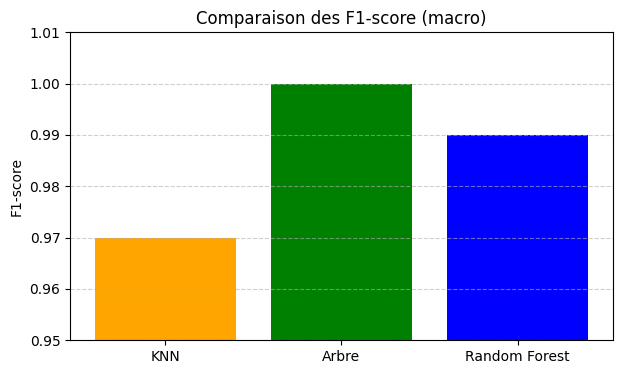

In [21]:
import matplotlib.pyplot as plt

# Résumé des F1-scores macro
models = ["KNN", "Arbre", "Random Forest"]
f1_scores = [0.97, 1.00, 0.99]

plt.figure(figsize=(7, 4))
plt.bar(models, f1_scores, color=["orange", "green", "blue"])
plt.ylim(0.95, 1.01)
plt.title("Comparaison des F1-score (macro)")
plt.ylabel("F1-score")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


##### Matrices de confusion – Trois modèles côte à côte

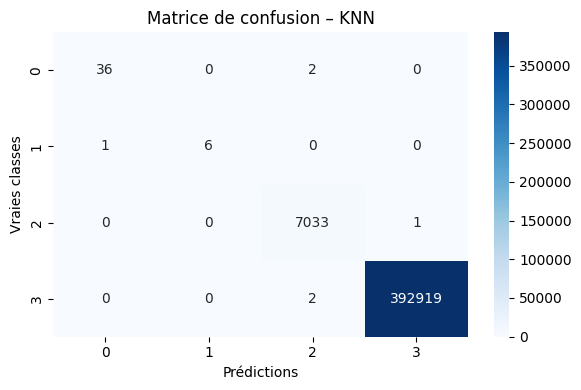

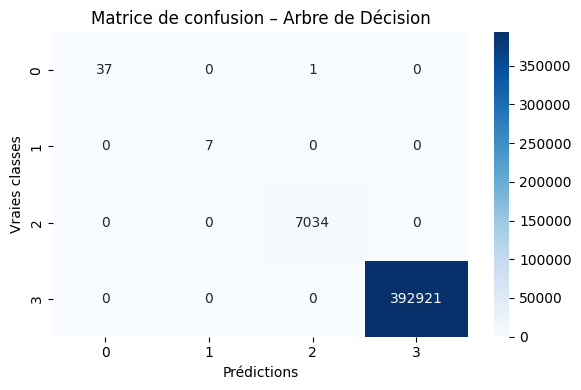

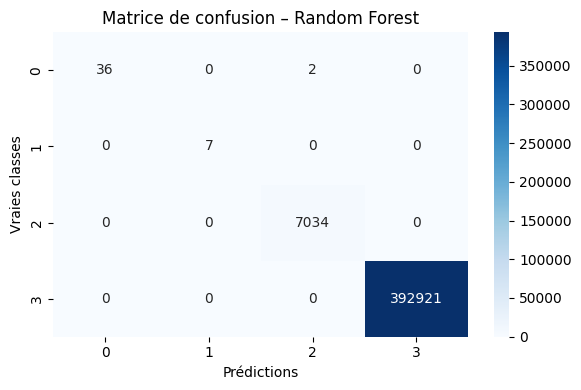

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(title, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies classes")
    plt.tight_layout()
    plt.show()

# Matrice de confusion KNN
plot_confusion("Matrice de confusion – KNN", y_test, y_pred_knn)

# Matrice de confusion Arbre de Décision
plot_confusion("Matrice de confusion – Arbre de Décision", y_test, y_pred_tree)

# Matrice de confusion Random Forest
plot_confusion("Matrice de confusion – Random Forest", y_test, y_pred_forest)


##### Graphique en courbe – Comparaison Accuracy & F1-score


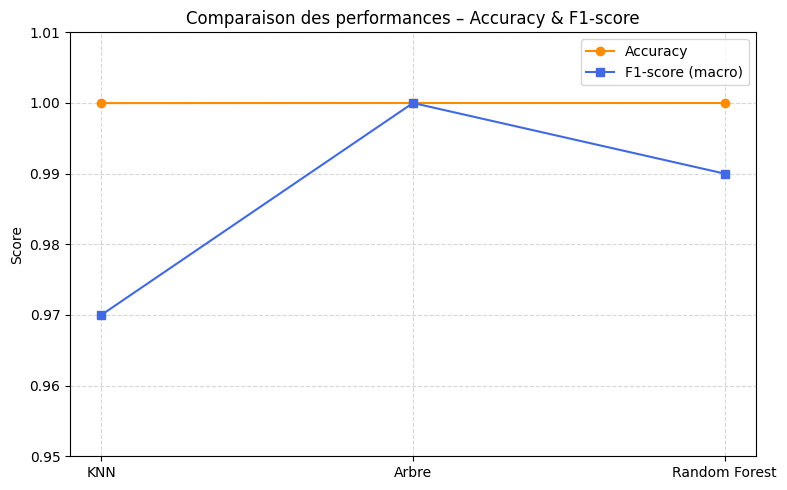

In [23]:
# Valeurs de performance
models = ["KNN", "Arbre", "Random Forest"]
accuracy_scores = [0.999985, 1.0, 1.0]
f1_macro_scores = [0.97, 1.0, 0.99]

# Visualisation
plt.figure(figsize=(8, 5))
plt.plot(models, accuracy_scores, marker='o', label="Accuracy", color='darkorange')
plt.plot(models, f1_macro_scores, marker='s', label="F1-score (macro)", color='royalblue')
plt.title("Comparaison des performances – Accuracy & F1-score")
plt.ylabel("Score")
plt.ylim(0.95, 1.01)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


#####  Partie 5– Analyse critique


#####  1. Quelles classes sont bien reconnues ? Celles qui posent problème ?


##### L’analyse détaillée des performances classe par classe, à travers les rapports de classification et les matrices de confusion obtenus pour chacun des trois modèles testés (KNN, Arbre de Décision, Random Forest), nous permet de distinguer clairement les classes bien reconnues de celles qui présentent des difficultés de prédiction.

a- Nous observons que les classes 2 et 3 sont systématiquement bien reconnues par l’ensemble des modèles, indépendamment de leur complexité :

- La classe 3, largement majoritaire dans notre jeu de données (près de 393 000 exemples), est quasiment parfaitement prédite par tous les modèles. Cela s’explique par le fait qu’un nombre élevé d’exemples permet aux algorithmes d’apprentissage supervisé de repérer facilement des schémas répétitifs et de généraliser efficacement.

- La classe 2 (environ 7000 exemples) est également très bien détectée, avec des précision, rappel et F1-score égaux à 1.00 dans la majorité des cas. Elle présente donc des caractéristiques suffisamment distinctes pour être reconnue sans ambiguïté par les modèles.

Ces deux classes bénéficient d’un volume d’apprentissage suffisant, ce qui réduit le risque de confusion avec d’autres classes et renforce la robustesse de la prédiction.

b- En revanche, les classes 0 et 1 posent davantage de difficultés, en particulier avec le modèle KNN.

- La classe 0 (environ 38 exemples dans le jeu de test) affiche un rappel inférieur à 1.00 dans les trois modèles testés. Cela signifie que certains exemples de cette classe sont mal classés, souvent confondus avec la classe 3. Cette confusion est logique, dans la mesure où la classe 3 domine le jeu de données, et où KNN, par exemple, peut être influencé par ses voisins les plus nombreux, menant à un biais vers la classe majoritaire.

- La classe 1 est encore plus problématique. Elle contient seulement 7 exemples dans le jeu de test. Même si l’Arbre de Décision et la Random Forest la reconnaissent bien, le modèle KNN commet des erreurs sur cette classe, ce qui confirme la vulnérabilité des méthodes à base de voisinage en contexte de classes rares.

#####  2. Quelles limitations les modèles présentent-ils (coût, surapprentissage...) ?

Bien que les modèles de classification que nous avons mis en œuvre (KNN, Arbre de Décision, Random Forest) aient montré des performances globalement excellentes, ils ne sont pas exempts de limitations, qu’il est essentiel de prendre en compte avant toute tentative de déploiement en environnement réel.

Nous abordons ici les principales contraintes observées en termes de coût de calcul, de risque de surapprentissage, de scalabilité, et d’interprétabilité.

a-  Coût computationnel

L’un des premiers facteurs limitants concerne le coût en ressources des modèles, notamment pour des jeux de données volumineux comme celui utilisé dans notre projet.

- Le modèle KNN présente un coût élevé à la prédiction. Contrairement à d’autres modèles qui apprennent une structure fixe lors de l’entraînement, KNN stocke l’ensemble des données et calcule les distances à chaque nouvelle prédiction. Ce mécanisme est lourd et peu adapté au temps réel, surtout avec un nombre d’exemples dépassant plusieurs centaines de milliers.

- L’Arbre de Décision, en revanche, est très rapide en prédiction, mais peut avoir un coût élevé en mémoire si la profondeur de l’arbre devient trop importante. Heureusement, scikit-learn gère efficacement la construction de ces arbres avec des heuristiques de coupure.

- Le Random Forest, composé de plusieurs arbres (souvent des dizaines ou centaines), demande plus de temps pour l’entraînement que l’arbre simple, mais reste relativement rapide à l’inférence grâce au traitement parallèle. Il constitue un bon compromis entre performance et efficacité.

b- Surapprentissage (overfitting)

Le surapprentissage constitue une autre limite majeure, en particulier pour les modèles qui s’adaptent trop fidèlement aux données d’apprentissage, au détriment de leur capacité à généraliser à de nouvelles données.

- L’Arbre de Décision est le plus exposé à ce risque. Lorsqu’aucune profondeur maximale n’est définie, l’arbre peut continuer à se ramifier jusqu’à mémoriser quasiment chaque exemple du dataset. Cela conduit à un apprentissage trop spécifique, qui échoue dès que des cas légèrement différents sont présentés.

- Le KNN, bien qu’il ne “sur-apprend” pas au sens classique, peut être très sensible au bruit ou aux outliers, surtout avec un petit k. Cela peut se traduire par des décisions locales incohérentes.

- Le Random Forest, quant à lui, limite fortement le surapprentissage, grâce à sa stratégie d’agrégation aléatoire (bagging). Chaque arbre apprend sur une portion différente des données, ce qui rend l’ensemble plus robuste. Toutefois, si le nombre d’arbres est trop petit, ou si les arbres ne sont pas suffisamment profonds, le modèle peut au contraire sous-apprendre.

c- Scalabilité

En termes de scalabilité, c’est-à-dire la capacité à s’adapter à un volume croissant de données ou de caractéristiques, les modèles présentent également des différences notables :

- KNN ne scale pas bien : plus le dataset est grand, plus le temps de prédiction augmente, car il faut comparer chaque point test à tous les points d’entraînement.

- Arbre de Décision et Random Forest sont plus adaptés aux jeux de données de taille moyenne à grande, et peuvent même être parallélisés facilement.

- Aucun des modèles implémentés ici n’est vraiment adapté aux flux de données temps réel ou à des mises à jour dynamiques sans réentraînement complet.

d- Interprétabilité

L’interprétabilité est un critère important, notamment dans des contextes sensibles (cybersécurité, médical, finance...).

- Le modèle Arbre de Décision est facilement interprétable : chaque prédiction peut être expliquée par une série de règles logiques simples.

- En revanche, la Random Forest, bien qu’issue d’arbres, devient difficile à interpréter à cause de la multitude d’arbres et de règles impliquées. C’est un modèle boîte noire partielle.

- Le KNN, lui, est très peu explicable : il ne donne pas de règles mais se contente de “copier” les classes de ses voisins les plus proches.

e- Sensibilité au déséquilibre des classes

Enfin, tous les modèles sont, à des degrés divers, sensibles aux déséquilibres dans les données.

- KNN et Arbre ont montré des faiblesses sur les classes rares, en particulier les classes 0 et 1, mal représentées dans notre dataset.

- La Random Forest a mieux résisté à ce biais, mais présente une légère baisse de F1-score macro, confirmant qu’un rééquilibrage explicite (par pondération ou suréchantillonnage) serait bénéfique.



#####  3. Proposez des améliorations :

 Plusieurs pistes concrètes pourraient être explorées pour améliorer significativement la robustesse, la précision, et l’adaptabilité du modèle dans des contextes plus exigeants.

 a- Validation croisée

  Mettre en place une validation croisée (k-fold) permettrait d’évaluer la stabilité des performances des modèles sur plusieurs partitions différentes du dataset. Cela éviterait de fonder toute l’évaluation sur un seul découpage aléatoire (train/test split), et donnerait une image plus fidèle de la capacité de généralisation des modèles.

 b- Optimisation des hyperparamètres

  Nouspourrions intégrer une étape d’optimisation automatique des hyperparamètres via GridSearchCV ou RandomizedSearchCV, notamment pour ajuster k dans le KNN, la profondeur maximale (max_depth) dans les arbres, ou le nombre d’arbres (n_estimators) dans la forêt aléatoire. Une telle démarche permettrait d’obtenir un modèle plus finement adapté aux spécificités des données.

 c- Réduction de dimensionnalité

  L'application de méthodes de réduction de dimensionnalité telles que l'ACP (PCA) pourrait permettre de conserver les variables les plus pertinentes, tout en simplifiant l'espace de représentation pour les modèles. Cela améliorerait potentiellement la vitesse d'exécution et réduirait le bruit.

 d- Utilisation de modèles avancés

  Nous pourrions envisager l’utilisation de modèles plus sophistiqués, comme les réseaux de neurones multi-couches (MLP) ou les modèles de boosting tels que XGBoost et LightGBM, qui sont souvent très performants sur des données structurées. Ces approches pourraient aussi mieux capter des interactions complexes entre les variables.

 e- Mise en production / POC
 
  Enfin, une extension naturelle serait de construire un prototype fonctionnel (Proof of Concept), intégrant le modèle dans une API REST ou une interface graphique permettant :
 - La prédiction en temps réel sur de nouveaux flux
 - La visualisation dynamique des prédictions et performances
 - La journalisation des prédictions pour rétroanalyse

##### 5.3 – Dans quels cas d’usage concret ce système pourrait-il être déployé ? (FAI, entreprise, cybersécurité…)

Les modèles développés dans ce projet — bien qu’issus d’un cadre académique — présentent un **potentiel réel d’application dans plusieurs domaines professionnels**. Leur capacité à **classifier automatiquement le trafic réseau**, en identifiant le type d’usage associé à chaque flux (streaming, VoIP, attaque, etc.), peut constituer un **outil stratégique dans de nombreux environnements connectés**.


1- Entreprises (grandes ou PME)

Dans le contexte d’une entreprise, ce système pourrait être intégré à une **infrastructure de surveillance réseau interne**. Son rôle serait de :

* **Surveiller en temps réel l’utilisation du réseau**, pour comprendre quels services ou applications sont les plus utilisés (YouTube, navigation web, VoIP, etc.)
* **Identifier des comportements anormaux** ou des usages non autorisés
* **Optimiser la bande passante**, en différenciant les flux critiques des flux non prioritaires

Ce type de solution aiderait les administrateurs réseau à prendre des décisions éclairées sur les politiques de pare-feu, de qualité de service (QoS), ou de sécurité.

2- Fournisseurs d’Accès à Internet (FAI)

Les fournisseurs d’accès à Internet, qu’ils soient nationaux ou régionaux, peuvent également bénéficier de ce type de solution pour :

* **Analyser anonymement les tendances de consommation** de leurs utilisateurs (type de trafic, pics de charge, etc.)
* **Optimiser la répartition de ressources et l’acheminement du trafic**, en fonction des usages les plus fréquents (vidéo, jeux, télétravail…)
* **Mettre en place des politiques de gestion de trafic équitables**, sans interdire de service, mais en favorisant une fluidité maximale

Bien entendu, cela doit se faire dans le respect strict de la **réglementation sur la vie privée** (RGPD), avec des solutions de classification opérant sur des données anonymisées.

3- Cybersécurité (SOC, pare-feu, SIEM)

Le domaine le plus critique où notre système peut être utile est celui de la **cybersécurité**. Intégré à un **centre de supervision de la sécurité (SOC)** ou à un **système de détection/prévention d’intrusion (IDS/IPS)**, il permettrait :

* De **détecter automatiquement les flux malveillants**, en classifiant certains types de trafic comme suspects (e.g. scans, DDoS, connexions non standards)
* D’**alerter en temps réel** en cas de changement soudain de comportement réseau (trafic sortant massif, nouvelle classe détectée, etc.)
* D’**améliorer les capacités de corrélation** dans les solutions SIEM (Security Information and Event Management), en enrichissant les logs avec un tag de “type de trafic”

Dans ce cadre, le modèle pourrait fonctionner **en tandem avec des outils comme Suricata, Zeek ou Wireshark**, et offrir une classification automatique des flux capturés.


4- Réseaux domestiques intelligents

Enfin, une version simplifiée de ce système pourrait être embarquée dans **un routeur domestique intelligent** ou dans une **solution de contrôle parental avancé** :

* Pour **catégoriser automatiquement les usages réseau** (jeux, streaming, navigation)
* Pour **mettre en pause certains flux** à certaines heures (ex. bloquer le streaming pendant les devoirs)
* Pour **protéger le domicile contre des connexions inhabituelles**



En somme, les cas d’usage de notre système de classification réseau sont nombreux et variés. Ils vont **du diagnostic réseau à l’optimisation, en passant par la détection de menaces**. Grâce à sa structure modulaire, ce système pourrait être adapté à différents **niveaux d’exigence (temps réel, embarqué, cloud)**, et constitue un **excellent point de départ pour un projet de cybersécurité ou d’observabilité réseau**.

